# 1. Data

In [1]:
fn1 = "rayan"
ln1 = "charrier"
fn2 = "manon"
ln2 = "rivoire"

filename = "_".join(map(lambda s: s.strip().lower(), 
                        ["Computer_Lab_Quantile_Regression", ln1, fn1, "and", ln2, fn2])) + ".ipynb"

print(filename)

computer_lab_quantile_regression_charrier_rayan_and_rivoire_manon.ipynb


In [0]:
import numpy as np
from numpy.linalg import norm
import matplotlib.pyplot as plt
import scipy.optimize as so
import math

In [0]:
from census_dataset import load_data
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from scipy.io import loadmat
from tqdm import tqdm

def load_data(filename='census_data.mat', test_size=0.99):
    data = loadmat(filename)
    X = data.get('A')  # Educational Attainment
    X = np.asarray(X, dtype='float64')
    # Variables
#    Sex
#    Age in 30 40
#    Age in 40 50
#    Age in 50 60
#    Age in 60 70
#    Age gte 70
#    Non white*
#    Unmarried
#    Education
#    Education code squared
    # Education
    #00 Not in universe (Under 3 years)
    #01 No schooling completed
    #02 Nursery school to 4th grade
    #03 5th grade or 6th grade
    #04 7th grade or 8th grade
    #05 9th grade
    #06 10th grade
    #07 11th grade
    #08 12th grade, no diploma
    #09 High school graduate
    #10 Some college, but less than 1 year
    #11 One or more years of college, no degree
    #12 Associate degree
    #13 Bachelorâ€™s degree
    #14 Masterâ€™s degree
    #15 Professional degree
    #16 Doctorate degree
    y = data.get('b')[:, 0].reshape(-1, 1)
    del data
    ind = np.nonzero(y == 0.)[0]  # remove samples with no income
    X = np.delete(X, ind, axis=0)
    y = np.delete(y, ind, axis=0)
    X = np.delete(X, 1, axis=1)  # this variable is just ones everywhere

    scaler_x = StandardScaler()
    scaler_y = StandardScaler()

    X_train, X_test, y_train, y_test = train_test_split(X, y,
                                test_size=test_size, random_state=0)
    X_train = scaler_x.fit_transform(X_train)
    y_train = scaler_y.fit_transform(y_train)
    X_test = scaler_x.transform(X_test)
    y_test = scaler_y.transform(y_test)

    return X_train, X_test, y_train, y_test

In [0]:
X_train, X_test, y_train, y_test = load_data("census_data.mat")

In [5]:
!wget https://perso.telecom-paristech.fr/ofercoq/tp_qr/census_data.mat

--2019-12-22 21:27:02--  https://perso.telecom-paristech.fr/ofercoq/tp_qr/census_data.mat
Resolving perso.telecom-paristech.fr (perso.telecom-paristech.fr)... 137.194.2.165, 2001:660:330f:2::a5
Connecting to perso.telecom-paristech.fr (perso.telecom-paristech.fr)|137.194.2.165|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 33091048 (32M)
Saving to: ‘census_data.mat.1’

census_data.mat.1   100%[===================>]  31.56M  2.59MB/s    in 17s     

2019-12-22 21:27:22 (1.84 MB/s) - ‘census_data.mat.1’ saved [33091048/33091048]



In [0]:
y_train = np.squeeze(y_train)
y_test = np.squeeze(y_test)

# 2. Quantile Regression With Linear Kernels

## Introduction

For $\tau \in (0,1)$, let us consider the pinball loss defined as : 
\begin{equation}
  L_{\tau}(v) = max(-(1-\tau)v, \tau v)
\end{equation} 

In [0]:
def l(t, v):
  """
  Inputs
  ----------
  tau: tau parameter
  v: argument of the function
  """
  return np.maximum(-(1-t)*v, t*v)

**Graphic visualization**

Text(0.5, 1.0, 'Tau = 0.7')

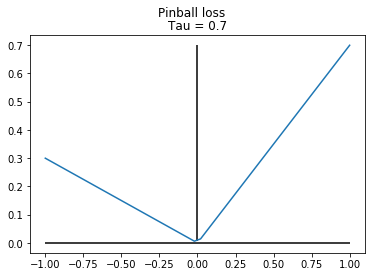

In [8]:
tau = 0.7
x = np.linspace(start=-1, stop=1, num=50)
y = [l(tau, v) for v in x]
plt.plot(x, y)
plt.hlines(xmin=x[0], xmax=x[-1], y=0)
plt.vlines(ymin=min(y), ymax=max(y), x=0)
plt.suptitle("Pinball loss")
plt.title("Tau = " + str(tau))

## Question 2.1

#### Statement

Calculate $L_{\tau}^{*}$, $prox_{\gamma L_{\tau}^{*}} (v)$, and $prox_{\gamma L_{\tau}}(v)$ for $\gamma > 0$. <br/>
The quantile regression problem consists in estimating conditional quantiles. given a pair of random variables $(X,Y) \in \mathbb{R}^{d} \times \mathbb{R}$ and a number $\tau \in [0,1]$, our goal is to estimate the conditional quantile function : 
\begin{equation}
  \mu_{\tau}(x) = inf\{\mu \in \mathbb{R} : \mathbb{P} (Y \leq \mu | X = x) \geq \tau\}
\end{equation}

Given a training set ${(x_{i}, y_{i})}_{0 \leq i \leq n-1}$, we estimate the conditional quantile using the solution of the following optimization problem : 
\begin{equation}
  min_{w \in \mathbb{R}^{d}, w_{0} \in \mathbb{R}} \frac{\alpha}{2} \sum_{j = 1}^{d} w_{j}^2 + \sum_{i = 1}^{n} L_{\tau} (y_{i} - \sum_{j = 1}^{d} x_{i,j}w_{j} - w_{0})
\end{equation}

where $\alpha > 0$ is a regularization constant and set $\hat{\mu}_{\tau} (x) = \sum_{j = 1}^{d} x_{j}w_{j} - w_{0}$. In the rest of the lab, we shall take $\alpha = 1$. 

### Answer

#### Fenchel-Legendre transformation $L^{*}_{\tau}$

Fenchel Legendre Transform Definition : <br/>

\begin{equation}
  L_{\tau}^{*}(\phi) = sup_{x \in \mathbb{R}} (<x, \phi> - L_{\tau}(x))
\end{equation}

Interpretation of the Fenchel Legendre Transform : <br/>
The Fenchel Legendre Transform $L^{*}_{\tau}(\phi)$ corresponds to the opposite of the intercept of the highest affine minimizer of the function $L_{\tau}(x)$. <br/>
We are going to study the function $L_{\tau}(x)$. <br/>

\\


\begin{aligned}
  L_{\tau}(x) &= max(-(1-\tau)x, \tau x) \\
  &= \left\{
    \begin{array}{ll}
        -(1-\tau)x & \mbox{if } -(1-\tau)x > \tau x \\
        \tau x & \mbox{otherwise}
    \end{array}
\right. \\
&= \left\{
    \begin{array}{ll}
        -(1-\tau)x & \mbox{if } x < 0 \\
        \tau x & \mbox{if } x \geq 0
    \end{array}
\right.
\end{aligned}

\\

Therefore, we can realize that the function $L_{\tau}(v)$ is differentiable on $\mathbb{R}_{+}^{*}$ and on $\mathbb{R}_{-}^{*}$ but $L_{\tau}(v)$ is not differentiable in $0$. <br/>
The subdifferential of $L_{\tau}(v)$ is given as follows : 
$$
\partial L_{\tau}(x) = \left\{
    \begin{array}{11}
        -(1-\tau) & \mbox{if } x < 0 \\
        [-(1-\tau), \tau] & \mbox{if } x = 0 \\
        \tau  & \mbox{if } x \geq 0
    \end{array}
\right.
$$

We are going to make a cases disjunction in function of the slopes of the affine minimizers of $L_{\tau}(v)$. 
Let's denote by $\phi$ the slope of the minimizers of the function $L_{\tau}(v)$.

\begin{equation}
  L_{\tau}^{*}(\phi) = sup_{x \in \mathbb{R}} (<x, \phi> - L_{\tau}(x)) 
\end{equation}

\begin{equation}
  L_{\tau}^{*}(\phi) = sup_{x \in \mathbb{R}} (<x, \phi> - max(-(1-\tau)x, \tau x))
\end{equation}

\\


- **First Case:** $\phi < -(1-\tau)$
In this case we can realize that the affine function $<\phi, x> - L_{\tau}^{*}(\phi)$ cannot lower bound the function $L_{\tau}(x)$ on $\mathbb{R}_{-}^{*}$. Therefore, the intuition gives that the opposite of the intercept for that affine function must be $+\infty$. Let's formalize that. <br/>

\\


Let's consider the maximizing series $x_n = -n$. For every $n \in \mathbb{N}$ we have

\begin{aligned}
  L_{\tau}^{*}(\phi) &\geq \ <x_n, \phi> - max(-(1-\tau)x_n, \tau x_n) \\
  &\geq \ <-n, \phi> - max(+(1-\tau)n, -\tau n) \\
  &\geq \ <-n, \phi> - (n -\tau n) \\
  &\geq \ -\phi n - n + \tau n \\
  &= \ (-\phi -(1-\tau)) n
\end{aligned}


We have assumed that $\phi < -(1-\tau)$, that is $-\phi - 1 + \tau > 0$, thus : 
\begin{equation}
  \lim\limits_{\substack{n \rightarrow +\infty \\}} (-\phi - 1 + \tau)n = +\infty
\end{equation}

and  

\begin{equation}
  L_{\tau}^{*}(\phi) = + \infty
\end{equation}

\\

- **Second Case:** $\phi > \tau$
In this case we can realize that the affine function $<\phi, x> - L_{\tau}^{*}(\phi)$ cannot lower bound the function $L_{\tau}(x)$ on $\mathbb{R}_{-}^{*}$. Therefore, the intuition gives that the opposite of the intercept for that affine function must be $+\infty$. Let's formalize that. <br/>


\\


Let's consider the maximizing series $x_n = +n$. For every $n \in \mathbb{N}$ we have

\begin{aligned}
  L_{\tau}^{*}(\phi) &\geq \ <x_n, \phi> - max(-(1-\tau)x_n, \tau x_n) \\
  &\geq \ <+n, \phi> - max(-(1-\tau)n, +\tau n) \\
  &\geq \ <+n, \phi> -\tau n \\
  &= \ (\phi -\tau) n
\end{aligned}


We have assumed that $\phi > \tau$, that is $\phi - \tau > 0$, thus : 
\begin{equation}
  \lim\limits_{\substack{n \rightarrow +\infty \\}} (-\phi - \tau)n = +\infty
\end{equation}

and  

\begin{equation}
  L_{\tau}^{*}(\phi) = + \infty
\end{equation}

\\


- **Third Case:** $\phi \in [-(1-\tau), \tau]$
In this case, the affine function $<\phi, x> - L_{\tau}^{*}(\phi)$ can minimize the function $L_{\tau}(x)$ in $0$. What is the opposite of the intercept of the highest minimizer of the function $L_{\tau}(x)$ ? Let's compute the Fenchel Legendre Transform. 

\begin{aligned}
  L_{\tau}^{*}(\phi) = sup_{x \in \mathbb{R}} (<x, \phi> - L_{\tau}(x)) \\
  &= sup_{x \in \mathbb{R}} (<x, \phi> - max(-(1-\tau)x, \tau x))
\end{aligned}


Let's distinguish two cases : <br/>
On the one hand, if $x < 0$ : <br/>

\begin{aligned}
  L_{\tau}^{*}(\phi) &= sup_{x \in \mathbb{R}} (<x, \phi> - (-(1-\tau)x)) \\
  &= sup_{x \in \mathbb{R}} (<x, \phi> + (1-\tau)x) \\
  &= sup_{x \in \mathbb{R}} (\phi + 1 - \tau)x
\end{aligned}


But we have assumed that $\phi \in [-(1-\tau), \tau]$, then $\phi \geq -(1- \tau)$, that is $\phi + 1 - \tau \geq 0$. And since we have assumed that $x < 0$, then we have $(\phi + 1 - \tau)x \leq 0$. Consequently, we obtain : 
\begin{equation}
  L_{\tau}^{*}(\phi) = sup_{x \in \mathbb{R}} (\phi + 1 - \tau)x = 0
\end{equation}

On the other hand, if $x \geq 0$ : <br/>
\begin{aligned}
  L_{\tau}^{*}(\phi) &= sup_{x \in \mathbb{R}} (<x, \phi> - \tau x) \\
  &= sup_{x \in \mathbb{R}} (\phi - \tau)x
\end{aligned}


But we have assumed that $\phi \in [-(1-\tau), \tau]$, then we have $\phi \leq \tau$, that is $\phi - \tau \leq 0$. And since we have assumed that $x \geq 0$, then we obtain that $(\phi - \tau)x \leq 0$. Consequently, we deduce that : 
\begin{equation}
  L_{\tau}^{*}(\phi) = sup_{x \in \mathbb{R}} (\phi - \tau)x = 0
\end{equation}

\\


**Conclusion:** <br/>
$$
L_{\tau}^{*}(\phi) = \left\{
    \begin{array}{11}
        +\infty & \mbox{if } \phi < -(1-\tau) \\
        0 & \mbox{if } \phi \in [-(1-\tau), \tau] \\
        +\infty  & \mbox{if } \phi > \tau
    \end{array}
\right.
$$

In [0]:
def l_star(tau, phi):
  """
  Inputs
  ----------
  tau: tau parameter
  phi: argument of the function
  """
  if -(1-tau) < phi and phi < tau:
    return 0
  else:
    return math.inf 

Text(0.5, 1.0, 'Tau = 0.7')

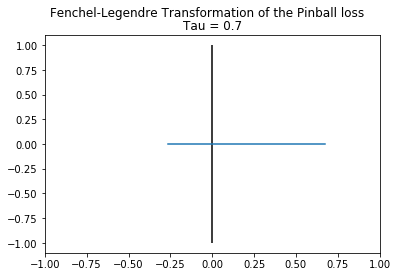

In [10]:
x = np.linspace(start=-1, stop=1, num=50)
y = [l_star(tau, v) for v in x]

plt.plot(x, y)
plt.axis(xmin=-1, xmax=1)
plt.vlines(x=0, ymin=-1, ymax=1)
plt.suptitle("Fenchel-Legendre Transformation of the Pinball loss")
plt.title("Tau = " + str(tau))

#### Proximal operators

- $prox_{\gamma L_{\tau}^{*} (v)}$

\begin{aligned}
  prox_{\gamma L_{\tau}^{*}} (v) &= argmin_{y \in \mathbb{R}} L_{\tau}^{*}(y) + \frac{1}{2\gamma} \left\|y-v\right\|^2 \\
  &= argmin_{y \in [-(1-\tau, \tau)]} \frac{1}{2\gamma} \left\|y-v\right\|^2 \\
  &= proj_{[-(1-\tau),\tau]}(v) \\
  &= \left\{
    \begin{array}{ll}
        -(1-\tau) & \mbox{if } v < -(1-\tau) \\
        v & \mbox{if } v \in [-(1-\tau), \tau] \\
        \tau & \mbox{if } v > \tau        
    \end{array}
\right.
\end{aligned}

In [0]:
def prox_l_star(gamma, tau, v):
  """
  Inputs
  ----------
  gamma: gamma parameter
  tau: tau parameter
  v: argument of the function
  """
  if v < -(1-tau):
    return -(1-tau)
  elif v > tau:
    return tau
  else:
    return v

Text(0.5, 1.0, 'Tau = 0.7, Gamma = 1')

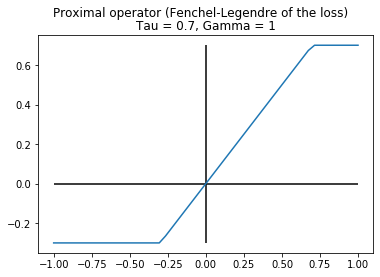

In [12]:
gamma = 1

x = np.linspace(start=-1, stop=1, num=50)
y = [prox_l_star(gamma, tau, v) for v in x]

plt.plot(x, y)
plt.hlines(xmin=x[0], xmax=x[-1], y=0)
plt.vlines(ymin=min(y), ymax=max(y), x=0)
plt.suptitle("Proximal operator (Fenchel-Legendre of the loss)")
plt.title("Tau = " + str(tau) + ", Gamma = " + str(gamma))

- $prox_{\gamma L_{\tau}}(v)$
\begin{equation}
  prox_{\gamma L_{\tau}} = argmin_{y \in \mathbb{R}} (L_{\tau}(y) + \frac{1}{2 \gamma}\left\|y-v\right\|^2) 
\end{equation}

From Fenchel Moreau Theorem we obtain the following statement : <br/>

\begin{aligned}
  prox_{\gamma L_{\tau}}(v) &= v - \gamma prox_{\frac{1}{\gamma}L_{\tau}^{*}}(\frac{v}{\gamma}) \\
  &= v - \gamma proj_{[-(1-\tau), \tau]}(\frac{v}{\gamma})
\end{aligned}



where $proj_{[-(1-\tau), \tau]}(\frac{v}{\gamma})$ is the orthognal projection of $\frac{v}{\gamma}$ onto the interval $[-(1-\tau), \tau]$.

\begin{aligned}
prox_{\gamma L_{\tau} (v)} &= \left\{
    \begin{array}{ll}
        v + \gamma (1-\tau) & \mbox{if } v < -\gamma (1-\tau) \\
        0 & \mbox{if } v \in [-\gamma(1-\tau), \gamma \tau] \\
        v- \gamma \tau & \mbox{if } v > \gamma \tau        
    \end{array}
\right.
\end{aligned}


In [0]:
def prox_l(gamma, tau, v):
  """
  Inputs
  ----------
  gamma: gamma parameter
  tau: tau parameter
  v: argument of the function
  """
  if v < -gamma*(1-tau):
    return v+gamma*(1-tau)
  elif v > gamma*tau:
    return v-gamma*tau
  else:
    return 0

Text(0.5, 1.0, 'Tau = 0.7, Gamma = 1')

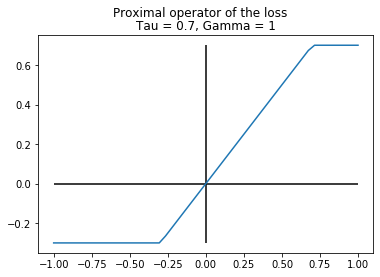

In [14]:
gamma = 1

x = np.linspace(start=-1, stop=1, num=50)
y = [prox_l_star(gamma, tau, v) for v in x]

plt.plot(x, y)
plt.hlines(xmin=x[0], xmax=x[-1], y=0)
plt.vlines(ymin=min(y), ymax=max(y), x=0)
plt.suptitle("Proximal operator of the loss")
plt.title("Tau = " + str(tau) + ", Gamma = " + str(gamma))

### What is Quantile Regression ? 



Quantile Regression is a type of regression analysis used in statistics and econometrics. Whereas the method of least squares results in estimates of the conditional mean of the response variable given certain values of the predictor variables : 
\begin{equation}
  \mathbb{E}[Y|X]
\end{equation}
Quantile Regression aims at estimating either the conditional median or other quantiles of the response variable. Essentially, Quantile Regression is the extension of linear regression and we use it when the conditions of linear regression are not applicable. <br/>
Quantile Regression is desired if conditional quantile functions are of interest. One advantage of quantile regression, relative to the ordinary least squares regression, is that the quantile regression estimates are more robust against outliers in the response measurements. However, the main attractio of quantile regression goes beyond that. Different measures of central tendency and statistical dispersion can be useful to obtain a more comprehensive analysis of the relationship between variables. <br/>

The mathematical forms arising from quantile regression are distinct from those arising in the method of least squares. The method of least squares leads to a consideration of problems in an inner product space, involving projection onto subspaces, and thus the problem of minimizing the squared errors can be reduced to a problem in numerical linear algebra. Quantile Regression does not have this structure, and instead leads to problems in linear programming that can be solved by the simplex method. <br/>

Let $Y$ be a real valued random variable with cumulative distribution function $F_{Y}(y) = \mathbb{P}(Y \leq y)$. The $\tau^{th}$ quantile of $Y$ is given by : 
\begin{equation}
  Q_{Y}(\tau) = F_{Y}^{-1}(\tau) = inf \{ y: F_{Y}(y) \geq \tau \}
\end{equation}

where $\tau \in (0,1)$. 

##  Question 2.2

### Statement

Define : 
\begin{equation}
  g : (w, w_{0}) \leftarrow \frac{\alpha}{2} \left \| w \right \|^2
\end{equation}

Calculate : 
\begin{equation}
  prox_{\gamma g}(w,w_{0})
\end{equation}

### Answer



\begin{equation}
  prox_{\gamma g}(w,w_{0}) = argmin_{(w',w_{0}') \in \mathbb{R}^2} (\frac{\alpha}{2} \left \| w' \right \|^2 + \frac{1}{2\gamma} \left \| w-w' \right \|^2 + \frac{1}{2\gamma} \left \| w_{0}-w_{0}' \right \|^2)
\end{equation}

\begin{equation}
  prox_{\gamma g}(w,w_{0}) = argmin_{w' \in \mathbb{R}, w_{0}' = w_{0}} (\frac{\alpha}{2} \left \| w' \right \|^2 + \frac{1}{2\gamma} \left \| w-w' \right \|^2)
\end{equation}

Let's denote by $f(w')$ the following function : 
\begin{equation}
  f(w') = \frac{\alpha}{2} \left \| w' \right \|^2 +\frac{1}{2\gamma} \left \| w-w' \right \|^2
\end{equation}
Now we are going to compute the gradient of the function $f$ with regards to $w'$ as follows : 
\begin{equation}
  \nabla f(w') = \alpha w' - \frac{w - w'}{\gamma}
\end{equation}

\begin{equation}
  \nabla f(w') = \alpha w' + \frac{w' - w}{\gamma}
\end{equation}

\begin{equation}
  \nabla f(w') = (\alpha + \frac{1}{\gamma}) w' - \frac{1}{\gamma}w
\end{equation}

Now we equate the gradient of $f$ to $0$ and we solve this optimization problem.

\begin{equation}
  \nabla f(w') = 0
\end{equation}


\begin{equation}
  (\alpha + \frac{1}{\gamma}) w' - \frac{1}{\gamma}w = 0
\end{equation}

$$
 \left\{
    \begin{array}{ll}
        w^{*} = \frac{w}{\alpha \gamma + 1} & \mbox{ } \\
        w_{0}^{*} = w_{0} & \mbox{}
    \end{array}
\right.
$$

\begin{equation}
  prox_{\gamma g}(w,w_{0}) = (w^{*}, w_{0}^{*}) 
\end{equation}

\begin{equation}
  prox_{\gamma g}(w,w_{0}) = (\frac{w}{\alpha \gamma + 1}, w_{0}) 
\end{equation}




## Question 2.3

### Statement

$\forall z \in \mathbb{R}^{n}$ denote :
\begin{equation}
  L_{\tau}(z) = \sum_{i = 1}^{n} L_{\tau}(z_{i})
\end{equation}
and $e = (1, \ldots, 1)$. <br/>
Show that :

1. 
\begin{equation}
  min_{w \in \mathbb{R}^{d}, w_{0} \in \mathbb{R}} \frac{\alpha}{2}  \left \| w \right \|^2 + L_{\tau}(y - xw - w_{0}e) = min_{w \in \mathbb{R}^{d}, w_{0} \in \mathbb{R}} max_{z \in \mathbb{R}^{n}} \frac{\alpha}{2}  \left \| w \right \|^2 - L_{\tau}^{*}(z) + z^{T} (y - xw - w_{0}e)
\end{equation}

2. 
\begin{equation}
  min_{w \in \mathbb{R}^{d}, w_{0} \in \mathbb{R}} \frac{\alpha}{2}  \left \| w \right \|^2 + L_{\tau}(y - xw - w_{0}e) = max_{z \in \mathbb{R}^{n}} y^{T}z - \frac{1}{2\alpha} \left \| x^{T}z \right \|^2 - L_{\tau}^{*}(z) - \iota_{0} (e^{T}z)
\end{equation}

3. 
\begin{equation}
  min_{w \in \mathbb{R}^{d}, w_{0} \in \mathbb{R}} \frac{\alpha}{2}  \left \| w \right \|^2 + L_{\tau}(y - xw - w_{0}e) = max_{z \in \mathbb{R}^{n}} min_{u \in \mathbb{R}} y^{T}z - \frac{1}{2\alpha} \left \| x^{T}z \right \|^2 - L_{\tau}^{*}(z) - ue^{T}z
\end{equation}

### Answer

#### Equality 1

\begin{aligned}
  max_{z \in \mathbb{R}^{n}} - L_{\tau}^{*}(z) + z^{T}(y - xw - w_{0}e) &= max_{z \in \mathbb{R}^{n}} <z, y - xw - w_{0}e> - L_{\tau}^{*}(z) \\
  &= L_{\tau}^{**}(y - xw - w_{0}e) \\
  &= L_{\tau}(y - xw - w_{0}e)
\end{aligned}


since the pinball loss $L_{\tau}$ is convex, continuous and lower semi-continuous, the convex enveloppe of $L_{\tau}$ is equal to the biconjugate of $L_{\tau}$ : 
\begin{equation}
  L_{\tau} = L_{\tau}^{**}
\end{equation}

Consequently we obtain : 
\begin{equation}
  min_{(w, w_{0}) \in \mathbb{R}^2} max_{z \in \mathbb{R}^{n}} \frac{\alpha}{2} \left \| w \right \|^2 - L_{\tau}^{*}(z) + z^{T}(y - xw - w_{0}e) = min_{(w, w_{0}) \in \mathbb{R}^2} \frac{\alpha}{2} \left \| w \right \|^2 + L_{\tau} (y - xw - w_{0}e)
\end{equation}


#### Equality 2

**Fenchel Rockafellar Theorem:** <br/>
Let $f : X \rightarrow (- \infty, + \infty]$ and $g : Y \rightarrow (- \infty, + \infty]$ be two convex functions and let $M : X \rightarrow Y$ be a linear operator. Assume that : 
\begin{equation}
  0 \in ri(M dom f - dom g)
\end{equation}

Then,

\begin{equation}
  inf_{x \in X} f(x) + g(Mx) = -min_{\phi \in Y} f^{*}(-M^{*}\phi + g^{*}(\phi))
\end{equation}

Now we have to identify the functions $f$, $g$ and the matrix M used in the Fenchel-Rockafellar Theorem. <br/>
Function $g$ : <br/>
\begin{equation}
  \forall z \in \mathbb{R}, \  g(z) = L_{\tau}(y + z)
\end{equation}

Function $f$ : <br/>
\begin{equation}
  \forall (w, w_{0}) \in \mathbb{R}^{d} \times \mathbb{R}, \ f(w, w_{0}) = \frac{\alpha}{2} \left \| w \right \|^2
\end{equation}

Matrix $M$ : <br/>

\begin{equation}
  M = [-X, -e]
\end{equation}

where : $X \in \mathbb{R}^{n \times d}$ is the Observations Matrix and $e = (0, 0, \ldots, 0, 1, 0, \ldots, 0) \in \mathbb{R}^{n}$. Therefore, $M \in \mathbb{R}^{n \times (d+1)}$

\\


**Condition of Qualification:** <br/>
We have : 
\begin{equation}
  dom(f) = \mathbb{R}^{d}
\end{equation}

\begin{equation}
  Mdom(f) \subset \mathbb{R}^{n}
\end{equation}

\begin{equation}
  ri(M dom(f) - dom(g)) = \mathbb{R}^{n}
\end{equation}

Thus

\begin{equation}
  0 \in ri(M dom(f) - dom(g))
\end{equation}

The condition of qualification is verified.

\\

**Applying the theorem**

We apply Fenchel Rockafellar Theorem with the functions $f$, $g$ and the matrix $M$. 

\begin{equation}
  inf_{(w, w_{0}) \in \mathbb{R}^{d} \times \mathbb{R}} f(w, w_{0}) + g(Mz) = max{(\phi, \phi_{0}) \in \mathbb{R}^{d} \times \mathbb{R}} -f^{*}(-M^{*}(\phi, \phi_{0}) - g^{*}(\phi, \phi_{0}))
\end{equation}

Let's write the formula of $f^{*}(\phi, \phi_{0})$ corresponding to the Fenchel Legendre Transform of the function $f$. 
Function $f$ : <br/>
\begin{equation}
  \forall (w, w_{0}) \in \mathbb{R}^{d} \times \mathbb{R} \ f(w, w_{0}) = \frac{\alpha}{2} \left \| w \right \|^2
\end{equation}

Let's write the Fenchel Legendre Transform of $f$ : 
\begin{equation}
  f^{*}(w, w_{0}) = max_{w, w_{0}} <w,\phi> + <w_{0}, \phi_{0}> - \frac{\alpha}{2} \left \| w \right \|^2
\end{equation}

We want to maximize a concave function $h$, therefore, we are going to compute the gradient of the function $h$ with regards to each variable $w$ and $w_{0}$, then we equate it to $0$ and we solve the optimization problem. 

Let's denote by $h$ the following function : <br/>

Gradient of $h$ with regards to $w$ : 
\begin{equation}
  \frac{\partial}{\partial w} h(w, w_{0}) = \phi - \alpha w 
\end{equation}

\\

\begin{equation}
\frac{\partial}{\partial w} h(w{*}, w_{0}) = 0 \Leftrightarrow \phi - \alpha w{*}  = 0 \Leftrightarrow w^{*}  = \frac{\phi}{\alpha}
\end{equation}


Gradient of $h$ with regards to $w_{0}$ : 

\begin{equation}
  \frac{\partial}{\partial w_{0}} h(w, w_{0}) = \phi_{0} 
\end{equation}

\\

\begin{equation}
\frac{\partial}{\partial w} h(w{*}, w_{0}) = 0 \Leftrightarrow \phi_{0} = 0 \Leftrightarrow w^{*}  = \frac{\phi}{\alpha}
\end{equation}

\\

**First Case:** $\phi_{0} = 0$

\begin{equation}
  <w_{0}, \phi_{0}> = 0
\end{equation}

**Second Case:** $\phi_{0} \ne 0$

Let's take a maximizing series defined as follows :
\begin{equation}
  w_{0_{n}} = n \times sign(\phi_{0}) = n |\phi_{0}|
\end{equation}

\begin{equation}
  \lim\limits_{\substack{n \rightarrow \infty}} n |\phi_{0}| = + \infty
\end{equation}

Therefore we have the following statement :
\begin{equation}
  sup_{w_{0} \in \mathbb{R}} w_{0}\phi_{0} = \iota_{0} (\phi_{0})
\end{equation}

Consequently, we obtain : 

\begin{aligned}
  f^{*}(\phi, \phi_{0}) &= <\frac{\phi}{\alpha}, \phi> + l_{0}(\phi_{0}) - \frac{\alpha}{2} \left \| \frac{\phi}{\alpha} \right \|^2 \\
  &= \frac{1}{\alpha} \left \| \phi \right \|^2 + \iota_{0}(\phi_{0}) - \frac{1}{2\alpha} \left \| \phi \right \|^2 \\
  &= \frac{1}{2\alpha} \left \| \phi \right \|^2 + \iota_{0}(\phi_{0})
\end{aligned}

And the Fenchel-Legendre Transform of the function $g$ is given as follows : 

\begin{aligned}
  g^{*}(\phi) &= max_{z} <z, \phi> - g(z) \\
  &= max_{z} <z, \phi> - L_{\tau}(y + z)
\end{aligned}


Let's performe the following variable change : $z' = y + z$

\begin{aligned}
  g^{*}(\phi) &= max_{z'} <z' - y, \phi> - L_{\tau}(z') \\
  &= max_{z'} <z' , \phi> - L_{\tau}(z') - <y, \phi> \\
  &= L_{\tau}^{*}(\phi) - <y, \phi>
\end{aligned}


Thus we obtain : 
\begin{equation}
  inf_{(w, w_{0}) \in \mathbb{R}^{d} \times \mathbb{R}} f(w, w_{0}) + g(Mz) = - min_{(\phi, \phi_{0})} f^{*} (-M^{*}(\phi, \phi_{0})) + g^{*}(\phi, \phi_{0})
\end{equation}

\begin{equation}
  M^{*}z = [-X^{*} \ e^{*}]z = [- X^{*}z \ e^{*}z] = [\phi \ \phi_{0}]
\end{equation}

\begin{equation}
  f^{*}(-M^{*}z) = \frac{1}{2 \alpha} \left \| X^{*}z \right \|^2 + \iota_{0}{e^{*}z}
\end{equation}

\begin{equation}
  g^{*}(z) = L_{\tau}^{*} - <y, z>
\end{equation}


Consequently we have proved the following result : 
\begin{equation}
  inf_{(w, w_{0}) \in \mathbb{R}^{d} \times \mathbb{R}} f(w, w_{0}) + g(Mz) = max_{z} - f^{*}(-M^{*}z) - g^{*}(z) 
\end{equation}

\begin{equation}
  inf_{(w, w_{0}) \in \mathbb{R}^{d} \times \mathbb{R}} f(w, w_{0}) + g(Mz) = max_{z} - \frac{1}{2\alpha} \left \| X^{*}z \right \|^2 - \iota_{0}(e^{*}z) - L_{\tau}^{*}(z) + <y, z>
\end{equation}

#### Equality 3

\begin{equation}
  max_{z \in \mathbb{R}^{n}} min_{u \in \mathbb{R}} y^{*}z - \frac{1}{2\alpha} \left \| X^{*}z \right \|^2 - L_{\tau}^{*}(z) - ue^{*}z
\end{equation}

$$
min_{u \in \mathbb{R}} - ue^{*}z = - max_{u \in \mathbb{R} ue^{*}z}  = \left\{
    \begin{array}{ll}
        + \infty & \mbox{if } \ e^{*}z \ne 0 \\
        0 & \mbox{otherwise.}
    \end{array}
\right.
$$

Therefore we obtain the following equality : 
\begin{equation}
  max_{z \in \mathbb{R}^{n}} min_{u \in \mathbb{R}} y^{*}z - \frac{1}{2\alpha} \left \| X^{*}z \right \|^2 - L_{\tau}^{*}(z) - ue^{*}z = max_{z \in \mathbb{R}^{n}} y^{*}z - \frac{1}{2\alpha} \left \| X^{*}z \right \|^2 - L_{\tau}^{*}(z) - \iota_{0} e^{*}z
\end{equation}

# 3. Implementation

## Question 3.1

### Statement

Implement at least two algorithms for the resolution of the quantile regression problem. You
may choose test size = 0.99 in order to test your algorithm on small data.

In [0]:
def opti_function(w, M, y, alpha=1, tau=0.7):
  """
  Inputs
  ----------
  w: parameters
  M: transformed matrix of the input data
  y: output data
  """
  return alpha/2*norm(w[1:])**2 + np.sum(np.apply_along_axis(lambda v: l(tau, v), 0, y-np.dot(M,w)))

### Augmented Method of Multipliers (ADMM) Algorithm

Using the notations of the course we aim at minimizing

\begin{equation}
f(w) + g(Mw)
\end{equation}

with
* $w = (w_0, w_1) \in \mathbb{R}^{d+1}$
* $f(w) = g(w_1) = \frac \alpha 2 ||w_1||^2$ (here $g$ is the function of the statement)
* $g(Mw) = \sum_i L_{\tau} (y_i - (Mw)_i)$ with $M^T = \Big( x'_1 | ... | x'_n \Big)$ and $x' = (1, x)$.

We thus have

\begin{equation}
g(.) = \sum_i L_{\tau} (y_i - ._i)
\end{equation}

\\

The algorithm introduced during the class is defined as follows:


$$
\left\{
    \begin{array}{11}
        w^{k+1} \in argmin_{w'} \ f(w') + <\phi^k, Mw'> + \frac 1 {2 \gamma} ||Mw'-z^k||^2\\
        z^{k+1} = argmin_{z'} \ g(z') - <\phi^k, z'> + \frac 1 {2 \gamma} ||Mw^{k+1} - z'||^2 \\
        \phi^{k+1} = \phi^k + \frac 1 {\gamma} (Mw^{k+1} - z^{k+1})
    \end{array}
\right.
$$

\\

For each iteration let's have a more explicit formula for $w^{k+1}$ and $z^{k+1}$.

- $w^{k+1}$

We are looking for

\begin{equation}
argmin_{w'} \ f(w') + <\phi^k, Mw'> + \frac 1 {2 \gamma} ||Mw'-z^k||^2 
\end{equation}

i.e.

\begin{equation}
argmin_{w'} \ \frac \alpha 2 ||w'_1||^2 + <\phi^k, Mw'> + \frac 1 {2 \gamma} ||Mw'-z^k||^2 
\end{equation}

with $w'_1$ the vector $w'$ without the first coordinate. We also note $w'_{-0}$ the vector $w'$ with a $0$ at the first coordinate.

We compute the gradient of the function in the argmin and the argmin is solution of

\begin{aligned}
\alpha w'_{-0} + M^T \phi^k + \frac 1 {\gamma} M^T (M w' - z^k) = 0
\end{aligned}

i.e. with $P_{-0} = diag(0, 1, ..., 1)$ we get the following equation for $w^{k+1}$:

\begin{aligned}
(\alpha P_{-0} + \frac 1 {\gamma} M^T M)w' = M^T (\frac 1 {\gamma} z^k-\phi^k).
\end{aligned}

Given the values of $P_0$ and the fact that $\alpha, \gamma > 0$, we can easily see that the eignvalues of the left matrix are all strictly positive if M is injective.

We can indeed diagonalize the matrix $M^TM$ and use the same decomposition for $P_0$. The injectivity of $M$ plays a role regarding the first coordinate in position $(1,1)$, as we have $P_0(1,1) = 0$ and $M^T M > 0$ as the first colonne is different from zero due to the injectivity.

We thus have

\begin{aligned}
w^{k+1} = (\alpha P_{-0} + \frac 1 {\gamma} M^T M)^{-1}(\frac 1 {\gamma} M (z^k-\phi^k))
\end{aligned}

\\

- $z^{k+1}$

\begin{aligned}
z^{k+1} &= argmin_{z'} \ g(z') - <\phi^k, z'> + \frac 1 {2 \gamma} ||Mw^{k+1} - z'||^2 \\
&= argmin_{z'} \ g(z') + \frac 1 {2 \gamma} ||z' - \Big( \gamma \phi^k + M w^{k+1} \Big)||^2 \\
&= prox_{\gamma g}(\gamma \phi^k + M w^{k+1}).
\end{aligned}

Given that $g$ is separable we can compute the proximal operator coordinate by coordinate and use

\begin{equation}
\Big( prox_{\gamma g}(.) \Big)_i = y_i - prox_{\gamma L_{\tau}}(.).
\end{equation}


In [0]:
alpha = 1

def ADMM(alpha, gamma, tau, M, y, nb_iter = 100, w_init=None, phi_init=None, z_init=None):
  """
  Inputs
  ----------
  alpha: alpha parameter
  gamma: gamma parameter
  tau: tau parameter
  M: matrix of the data
  y: y vector
  nb_iter: number of iterations
  w_init : array of initial values
  phi_init : array of initial values
  z_init : array of initial values
  """
  
  # various parameters
  n, d = M.shape[0], M.shape[1]-1
  P_0 = np.diag(np.array([0]+d*[1]))

  # initial parameters
  if w_init is None:
    w_init = np.zeros(d+1)  # des zeros partout une bonne idée ?
  if z_init is None:
    z_init = np.zeros(n)
  if phi_init is None:
    phi_init = np.zeros(n)

  # evolution of the optimization function
  f = [opti_function(w_init, M, y, alpha, tau)]

  w_old, phi_old, z_old = w_init, phi_init, z_init

  # the algorithm in itself
  for i in range(nb_iter):
    w_new = np.linalg.inv(alpha*P_0 + 1/gamma*np.dot(M.T, M)).dot(1/gamma*(M.T).dot(z_old - phi_old))
    z_new = y - np.vectorize(lambda v: prox_l(gamma, tau, v))(gamma*phi_old + np.dot(M, w_new))
    phi_new = phi_old + 1/gamma*(np.dot(M, w_new) - z_new)

    f += [opti_function(w_new, M, y, alpha, tau)]
    w_old, phi_old, z_old = w_new, phi_new, z_new

  plt.plot(f)

  return w_new, phi_new, z_new

(array([ 0.12382411, -0.11797702,  0.09369385,  0.1264348 ,  0.12367691,
         0.0730822 ,  0.03960434, -0.02745213,  0.03607073, -0.08910022,
         0.30071112]),
 array([610.55433747, 732.03671525, 102.85974063, ..., 200.9861881 ,
          7.48102808, 274.67140367]),
 array([-336.02187651, -402.36478933,  -56.25804358, ..., -110.24926928,
          -3.77415328, -150.19901855]))

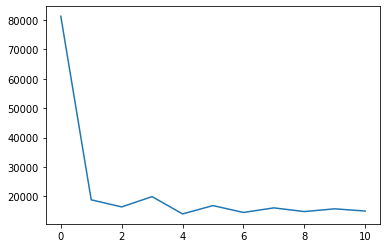

In [17]:
tau = 0.7
n = X_train.shape[0]
d = X_train.shape[1]
M = np.concatenate((np.ones((n,1)), X_train), axis=1)
gamma = 1.1
alpha = 1
sigma = norm(M, ord=2)**2

ADMM(alpha, gamma, tau, M, y_train, nb_iter = 10, w_init=np.random.normal(size=d+1), phi_init=np.random.normal(size=n), z_init=np.random.normal(size=n))

### Vu-Condat Algorithm

Using the notations of the course we aim at minimizing

\begin{equation}
f(w) + g(w) + h(Mw)
\end{equation}

with
* $w = (w_0, w_1) \in \mathbb{R}^{d+1}$
* $f(w) = g(w_1) = \frac \alpha 2 ||w_1||^2$
* $g = 0$ ($g$ here is the function from the algorithm definition)
* $h(Mw) = \sum_i L_{\tau} (y_i - (Mw)_i)$ with $M^T = \Big( x'_1 | ... | x'_n \Big)$ and $x' = (1, x)$.

We thus have

\begin{equation}
h(.) = \sum_i L_{\tau} (y_i - ._i)
\end{equation}

\\

The algorithm introduced during the class is defined as follows:


$$
\left\{
    \begin{array}{11}
        z^{k+1} = argmin_{z'} \ h(z') - <z',\phi^k> + \frac 1 {2 \gamma} ||z' - Mw^k||^2\\
        \phi^{k+1} = \phi^k + \frac 1 {\gamma} (Mw^k - z^{k+1})\\
        w^{k+1} = argmin_{w'} \ <\nabla f(w^k), w'> + <M^T(2\phi^{k+1} - \phi^k),w'> + \frac 1 {2 \delta} ||w'-w^k||^2
    \end{array}
\right.
$$

\\

For each iteration let's have a more explicit formula for $z^{k+1}$ and $w^{k+1}$.

- $z^{k+1}$

First, we have

\begin{aligned}
- <z',\phi^k> + \frac 1 {2 \gamma} ||z' - Mw^k||^2 &= \frac 1 {2 \gamma} ||z'||^2 - <z', \phi^k + \frac 1 {\gamma} M w^k> + \ c^{te} \\
&= \frac 1 {2 \gamma} || z' - (\gamma \phi^k + M w^k)||^2 + \ c^{te}
\end{aligned}

and

\begin{aligned}
z^{k+1} &= argmin_{z'} \ h(z') - <z',\phi^k> + \frac 1 {2 \gamma} ||z' - Mw^k||^2\\
&= argmin_{z'} \ h(z') + \frac 1 {2 \gamma} || z' - (\gamma \phi^k + M w^k)||^2 \\
&= prox_{\gamma h} (\gamma \phi^k + M w^k)
\end{aligned}

\\

The issue is now to compute $prox_{\gamma h}$. Considering the fact that $h$ is a separable function we can compute the argmin coordinate by coordinate and use

\begin{equation}
\Big( prox_{\gamma h}(.) \Big)_i = y_i - prox_{\gamma L_{\tau}}(.).
\end{equation}

\\

- $w^{k+1}$

If we write $w^k_{-0}$ the vector $w^k$ with the first coordinate equal to $0$, we have

\begin{equation}
\nabla f(w^k) = w^k_{-0}
\end{equation}

and


\begin{aligned}
w^{k+1} &= argmin_{w'} \ <w', \alpha w^k_{-0} + M^T(2 \phi^{k+1} - \phi^k)> + \frac 1 {2 \delta} ||w'-w^k||^2 \\
&= w^k - \delta \Big[ \alpha w^k_{-0} + M^T(2 \phi^{k+1} - \phi^k) \Big].
\end{aligned}

*(by looking for a zero of the gradient)*.

In [0]:
def Vu_Condat(alpha, gamma, delta, tau, M, y, nb_iter = 100, w_init=None, phi_init=None, z_init=None):
  """
  Inputs
  ----------
  alpha: alpha parameter
  gamma: gamma parameter
  delta: deta parameter
  tau: tau parameter
  M: matrix of the data
  y: y vector
  nb_iter: number of iterations
  w_init : array of initial values
  phi_init : array of initial values
  z_init : array of initial values
  """
  
  # various parameters
  n, j = M.shape[0], M.shape[1]-1

  # initial parameters
  if w_init is None:
    w_init = np.zeros(j+1)  # des zeros partout une bonne idée ?
  if z_init is None:
    z_init = np.zeros(n)
  if phi_init is None:
    phi_init = np.zeros(n)

  # evolution of the optimization function
  f = [opti_function(w_init, M, y, alpha, tau)]

  w_old, phi_old, z_old = w_init, phi_init, z_init

  # the algorithm in itself
  for i in range(nb_iter):
    z_new = y - np.vectorize(lambda v: prox_l_bis(gamma, tau, v))(gamma*phi_old + np.dot(M, w_old))
    phi_new = phi_old + 1/gamma*(np.dot(M, w_old) - z_new)

    w_minus_0 = w_old.copy()
    w_minus_0[0] = 0

    w_new = w_old - delta*(alpha*w_minus_0 + np.dot(M.T,2*phi_new - phi_old))


    f += [opti_function(w_new, M, y, alpha, tau)]
    w_old, phi_old, z_old = w_new, phi_new, z_new

  plt.plot(f)
  
  return w_new, phi_new, z_new

From the course the parameters $\gamma$ and $\delta$ have to satisfy the following identity:

\begin{equation}
\delta < \frac 1 {\frac {\mathcal{L}(\nabla f)} 2 + \gamma ||M||^2}
\end{equation}

\\

Given that $\nabla f(w) = \alpha P_0 w$ we have $\mathcal{L}(\nabla f) = \alpha$.

The condition is then $\frac 1 {\delta} > \frac 1 2 + \gamma  ||M||^2$.

We take $\gamma$ such that both additive terms are of same order, i.e.
* $\gamma = \frac 1 {||M||^2}$
* $\frac 1 {\delta}$ = 1.1

In [0]:
def prox_l_bis(gamma, tau, v):
  """
  Inputs
  ----------
  gamma: gamma parameter
  tau: tau parameter
  v: argument of the function
  """
  if v < -gamma*(1-tau):
    return -(1-tau)
  elif v > gamma*tau:
    return tau
  else:
    return v/gamma

(array([-0.27886302, -0.24596113,  0.49387232,  0.56406615,  0.48665125,
         0.36081065,  0.1671041 , -0.03835566, -0.02950877,  0.03119187,
         0.33060087]),
 array([12.65906291,  3.90084109,  9.34763021, ...,  2.04884875,
        -3.86951776, -8.12540534]),
 array([-1.9039818 , -0.95919189, -0.84037248, ..., -0.88373164,
         0.21082433,  1.27050694]))

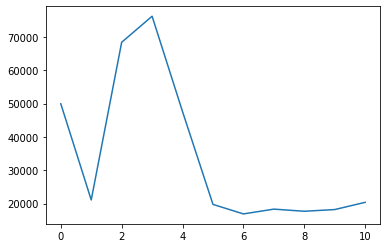

In [20]:
tau = 0.7
n = X_train.shape[0]
M = np.concatenate((np.ones((n,1)), X_train), axis=1)
gamma = 1.1
alpha = 1
sigma = (norm(M, ord=2)**2)
delta = 1/sigma
Vu_Condat(alpha, gamma, delta, tau, M, y_train, nb_iter = 10, w_init=np.random.normal(size=d+1), phi_init=np.random.normal(size=n), z_init=np.random.normal(size=n))

### Forward Backward Splitting 

In [0]:
def grad_term_reg(x, alpha):
  return alpha * np.concatenate(([0], x[1:]), axis=0)

In [0]:
def forward_backward_splitting(X, y_label, tau, alpha, gamma, lambd,w0=None, y0=None, n_iter=100, eps=0.001):
  n = X.shape[0]
  n_features = X.shape[1]
  M = np.concatenate((np.ones((n,1)), X), axis=1)
  e = np.ones((n))

  w = None or np.zeros((n_features+1,))
  y = None or np.zeros((n,))

  print(np.mean((M@w-y_label)**2))
  for i in range(n_iter):
    
    u = w - gamma*grad_term_reg(w, alpha)
    stop=False
    while not stop:
      v = y + lambd/gamma*M@(u-gamma*M.T@y)
      u = prox_l
      p = np.vectorize(lambda v: prox_l(gamma/lambd, tau, v))(y_label-gamma/lambd*v)
      y_new = v - lambd/gamma*y_label + lambd/gamma*p
      if norm(y_new-y)<=eps:
        stop = True
      y = y_new
    w = u - gamma*M.T@y
    if i %100==0:
      print(np.mean((M@w-y_label)**2))

In [23]:
w_init=np.random.normal(size=d+1)
y_init=np.random.normal(size=n)
forward_backward_splitting(X_train, y_train, 0.3, 0.2, 0.005, 1e-5, w_init , y_init, n_iter=10000, eps=1e-5)

1.0000000000000002


TypeError: ignored

## Question 3.2


### Statement

Define a stopping criterion. Why did you choose it ?

### Answer

We look at the relative difference between the successive values of the function to optimized. When that quantity doesn't vary much (the optimization doesn't prove efficient anymore), we stop the algorithm.

We take a threshold of 0.01 in order to ensure that we have reached a proper convergence.

Another issue is the early stopping: we define a good threshold in order to avoir the overfitting of our data.

In [0]:
def relative_diff(x1, x2, threshold):
  """
  Inputs
  ----------
  x1: reference value
  x2: second value
  threshold: threshold

  Outputs
  ----------
  bigger: boolean |(x1-x2)/x1| < threshold
  """
  bigger = (abs((x1-x2)/x1) > threshold)
  return bigger

We adapt our algorithms with that.

In [0]:
alpha = 1

def new_ADMM(alpha, gamma, tau, M, y, threshold=0.01, w_init=None, phi_init=None, z_init=None):
  """
  Inputs
  ----------
  alpha: alpha parameter
  gamma: gamma parameter
  tau: tau parameter
  M: matrix of the data
  y: y vector
  nb_iter: number of iterations
  w_init : array of initial values
  phi_init : array of initial values
  z_init : array of initial values
  """
  
  # various parameters
  n, d = M.shape[0], M.shape[1]-1
  P_0 = np.diag(np.array([0]+d*[1]))
  keep_going = True

  # initial parameters
  if w_init is None:
    w_init = np.zeros(d+1)  # des zeros partout une bonne idée ?
  if z_init is None:
    z_init = np.zeros(n)
  if phi_init is None:
    phi_init = np.zeros(n)

  # evolution of the optimization function
  f = [opti_function(w_init, M, y, alpha, tau)]

  w_old, phi_old, z_old = w_init, phi_init, z_init

  # the algorithm in itself
  while keep_going:
    w_new = np.linalg.inv(alpha*P_0 + 1/gamma*np.dot(M.T, M)).dot(1/gamma*(M.T).dot(z_old - phi_old))
    z_new = y - np.vectorize(lambda v: prox_l(gamma, tau, v))(gamma*phi_old + np.dot(M, w_new))
    phi_new = phi_old + 1/gamma*(np.dot(M, w_new) - z_new)

    f += [opti_function(w_new, M, y, alpha, tau)]
    w_old, phi_old, z_old = w_new, phi_new, z_new

    keep_going = relative_diff(f[-2], f[-1], threshold)

  return w_new, f


def new_Vu_Condat(alpha, gamma, delta, tau, M, y, threshold=0.01, w_init=None, phi_init=None, z_init=None):
  """
  Inputs
  ----------
  alpha: alpha parameter
  gamma: gamma parameter
  delta: deta parameter
  tau: tau parameter
  M: matrix of the data
  y: y vector
  nb_iter: number of iterations
  w_init : array of initial values
  phi_init : array of initial values
  z_init : array of initial values
  """
  
  # various parameters
  n, j = M.shape[0], M.shape[1]-1
  keep_going = True

  # initial parameters
  if w_init is None:
    w_init = np.zeros(j+1)  # des zeros partout une bonne idée ?
  if z_init is None:
    z_init = np.zeros(n)
  if phi_init is None:
    phi_init = np.zeros(n)

  # evolution of the optimization function
  f = [opti_function(w_init, M, y, alpha, tau)]

  w_old, phi_old, z_old = w_init, phi_init, z_init

  # the algorithm in itself
  while keep_going:
    z_new = y - np.vectorize(lambda v: prox_l_bis(gamma, tau, v))(gamma*phi_old + np.dot(M, w_old))
    phi_new = phi_old + 1/gamma*(np.dot(M, w_old) - z_new)

    w_minus_0 = w_old.copy()
    w_minus_0[0] = 0

    w_new = w_old - delta*(alpha*w_minus_0 + np.dot(M.T,2*phi_new - phi_old))

    f += [opti_function(w_new, M, y, alpha, tau)]
    w_old, phi_old, z_old = w_new, phi_new, z_new

    keep_going = relative_diff(f[-2], f[-1], threshold)

  return w_new, f

### Question 3.3 
Compare the performance of the algorithms you implemented on the census dataset with
$\tau = 0.7$ and test $size=0.33$.



In [0]:
X_train, X_test, y_train, y_test = load_data("census_data.mat", test_size=0.33)
y_train = np.squeeze(y_train)
y_test = np.squeeze(y_test)
n = X_train.shape[0]
M = np.concatenate((np.ones((n,1)), X_train), axis=1)

ADMM

In [0]:
w_admm, f_admm = new_ADMM(alpha, gamma, tau, M, y_train, threshold=0.01, w_init=np.random.normal(size=d+1), phi_init=np.random.normal(size=n), z_init=np.random.normal(size=n))

Vu-Condat

In [0]:
w_vucondat, f_vucondat = new_Vu_Condat(alpha, gamma, 1/(norm(M, ord=2)**2), tau, M, y_train, threshold=0.01, w_init=np.random.normal(size=d+1), phi_init=np.random.normal(size=n), z_init=np.random.normal(size=n))

Test

In [0]:
n = X_test.shape[0]
M = np.concatenate((np.ones((n,1)), X_test), axis=1)
f1 = opti_function(w_admm, M, y_test, alpha, tau)
f2 = opti_function(w_vucondat, M, y_test, alpha, tau)

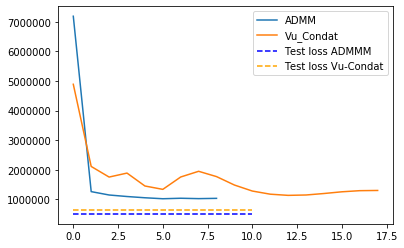

In [47]:
plt.plot(f_admm, label="ADMM")
plt.plot(f_vucondat, label="Vu_Condat")
plt.hlines(xmin=0, xmax=10, y=f1, label="Test loss ADMMM", linestyles="dashed", colors="blue")
plt.hlines(xmin=0, xmax=10, y=f2, label="Test loss Vu-Condat", linestyles="dashed", color = "orange")
plt.legend()
plt.show()

We can remark that the speed of convergence of the two algorithms ADMM and Vu-Condat are similar except the fact that the Vu-Condat Algorithm is less stable than the ADMM Algorithm. <br/>
Nevertheless, theoretically, the Vu-Condat algorithm is more suited than the ADMM algorithm to large scale optimization optimization problems. This is due to the fact that the linear operator M involved in both the ADMM and the Vu-Condat algorithms is never involved in complex subproblems in the Vu-Condat algorithm : this linear operator is only involved through matrix-vector multiplications. The counterpart of this computational advantage is that the Vu-Condat method usually requires more iterations than the ADMM algorithm to get an approximate solution of good quality.